<h1> Image Deblurring Project </h1>

<strong> Setting up </strong>

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
!pip install pylops
import pylops

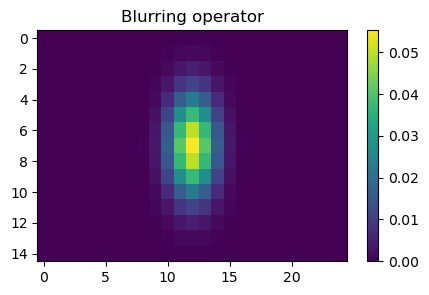

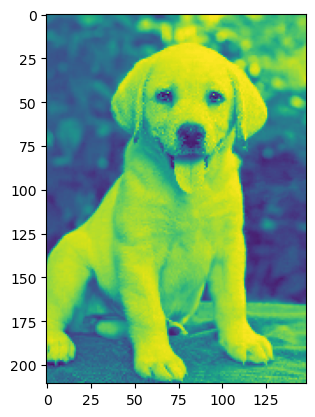

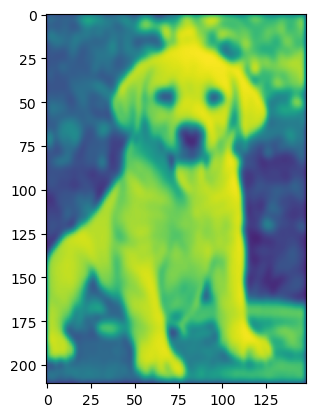

In [186]:
from matplotlib import image
sampling = 5
im = np.load("dog_rgb.npy")[::sampling, ::sampling, 2]
Nz, Nx = im.shape

# Blurring guassian operator
nh = [15, 25]
hz = np.exp(-0.1 * np.linspace(-(nh[0] // 2), nh[0] // 2, nh[0]) ** 2)
hx = np.exp(-0.3 * np.linspace(-(nh[1] // 2), nh[1] // 2, nh[1]) ** 2)
hz /= np.trapz(hz)  # normalize the integral to 1
hx /= np.trapz(hx)  # normalize the integral to 1
h = hz[:, np.newaxis] * hx[np.newaxis, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h)
ax.set_title("Blurring operator")
fig.colorbar(him, ax=ax)
ax.axis("tight")
plt.show()
Cop = pylops.signalprocessing.Convolve2D(
    (Nz, Nx), h=h, offset=(nh[0] // 2, nh[1] // 2), dtype="float32"
)

imblur = Cop * im 
plt.imshow(im, cmap="viridis", vmin=0, vmax=255)
plt.savefig('dog.pdf')
plt.show()
plt.imshow(imblur, cmap="viridis", vmin=0, vmax=255)
plt.savefig('dogblur.pdf')
plt.show()

In [187]:
def grad_f1(A,b,x):
    return(A.H@(A@x - b))

In [188]:
def fct(A,b,x,eps):
    return(0.5*np.linalg.norm(A@x-b)**2 + eps*np.linalg.norm(x,ord=1))   

In [189]:
def proximal(v,alpha,eps):
    n=np.size(v)
    w=alpha*eps*np.ones(n)
    return(np.sign(v)*np.maximum(np.abs(v)-w,np.zeros(n)))

In [190]:
def my_fista(A,b,opt_cost, eps=1e-1,niter=100,tol=1e-10,acceleration=False):
    
    """ Here you can code your ISTA and FISTA algorithm
        Return: optimal x, optimal gap: x(end)-x(end-1), and opt_gap_cost (history of cost-optcost)
    """
    M=A.H@A
    L=max(abs(M.eigs(neigs=1,symmetric=True)))
    alpha = 1/L
    m,n=A.shape
    x=np.zeros(n)
    v=np.zeros(n)
    z=np.zeros(n)   
    i=0
    gap_cost = fct(A,b,x,eps)-opt_cost   # fct(A,b,x,eps) = cost
    opt_gap_cost=[]
    
    # cas acceleration = false : ISTA
    if not acceleration:
        while i<niter and gap_cost>tol:
            v=x-alpha*grad_f1(A,b,x)
            z=x   # on sauvegarde la valeur précédente de x pour le opt_gap
            
            x=proximal(v,alpha,eps)

            gap_cost = fct(A,b,x,eps)-opt_cost
            opt_gap_cost.append(gap_cost)
            i+=1
    
    #cas acceleration = True  :  FISTA
   
    else : 
        yk1=np.zeros(n)
        v=x-alpha*grad_f1(A,b,x)
        for j in range(n):
                yk1[j]=np.sign(v[j])*(np.maximum(abs(v[j])-alpha*eps,0))
        yk2=np.zeros(n)   #correspond au yk+1
        lbda1 = 0   
    
        while i<niter and gap_cost>tol:
            
            lbda2 = 0.5*(1 + np.sqrt(1+4*lbda1**2))    #correspond au lambda(k+1)
            gamma = (1-lbda1)/lbda2
            
            v=x-alpha*grad_f1(A,b,x)
            z=x   # on sauvegarde la valeur précédente de x
            

            yk2=proximal(v,alpha,eps)
            
            x=gamma*yk1 + (1-gamma)*yk2
            gap_cost = fct(A,b,x,eps)-opt_cost
            opt_gap_cost.append(gap_cost)
            
            #actualisation
            yk1=yk2   
            lbda1=lbda2
            i+=1
    
        
    opt_gap=x-z
    
    
    return x, opt_gap, opt_gap_cost
    
        
        

In [220]:
def proximal_f1(A,b,v):
    m,n=A.shape
    I = np.eye(n, dtype=np.float16)
    x = np.linalg.solve((I + A.H@A),(A.H@b + v))
    return x

In [221]:
def Douglas_Rachford(A,b,opt_cost, eps=1e-1,niter=100,tol=1e-10):
    
    M=A.H@A
    L=max(abs(M.eigs(neigs=1,symmetric=True)))
    alpha = 1/L
    m,n=A.shape
    x=np.zeros(n)
    z=np.zeros(n)
    i=0
    opt_gap_cost=[]
    gap_cost = fct(A,b,x,eps)-opt_cost
    
    while i<niter and gap_cost>tol:

        x=proximal(z,1,eps)
        z= z + proximal_f1(A,b,2*x-z) - x
        opt_gap_cost.append(gap_cost)

        #actualisation
        i+=1


    return(opt_gap_cost)




In [222]:
Wop = pylops.signalprocessing.DWT2D((Nz, Nx), wavelet="haar", level=3)

#This is your A and b for your f1 cost!
A = Cop * Wop.H
b = imblur.ravel()

# Baseline from pylops
imdeblurfista0, n_eff_iter, cost_history = pylops.optimization.sparsity.fista(
    A, b, eps=1e-1, niter=1000
)

opt_cost = cost_history[-1] 

# ISTA
my_imdeblurfista, opt_gap, opt_gap_cost = my_fista(
    Cop * Wop.H, imblur.ravel(), opt_cost,eps=1e-1, niter=100, acceleration=False)

# FISTA
my_imdeblurfista1, opt_gap1, opt_gap_cost1 = my_fista(
    Cop * Wop.H, imblur.ravel(), opt_cost,eps=1e-1, niter=100, acceleration=True)

#Douglas-Rachford
opt_gap_cost2 = Douglas_Rachford(Cop * Wop.H, imblur.ravel(),opt_cost, eps=1e-1,niter=100,tol=1e-10)


plt.loglog(opt_gap_cost,'C0', label='ISTA')
plt.loglog(opt_gap_cost1,'C1', label='FISTA')
plt.loglog(opt_gap_cost12,'C2', label='douglas-rachford')
plt.grid()
plt.loglog([3, 30],[1e6, 1e5], 'C0--', label='1/k')
plt.loglog([3, 30],[.5e5, .5e3], 'C1--', label='1/k2')

plt.legend()
plt.show()

imdeblurfista = my_imdeblurfista1.reshape((Cop * Wop.H).dims)
imdeblurfista = Wop.H * imdeblurfista

MemoryError: Unable to allocate 8.00 GiB for an array with shape (65536, 65536) and data type float16

<strong> Image visualization </strong>

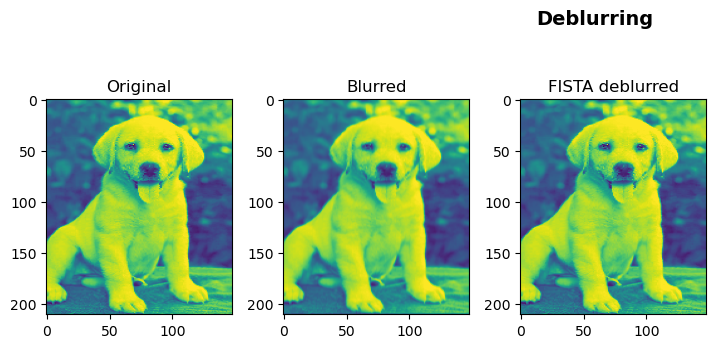

In [176]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Deblurring", fontsize=14, fontweight="bold", y=0.95)
ax1 = plt.subplot2grid((2, 5), (0, 0))
ax2 = plt.subplot2grid((2, 5), (0, 1))
ax3 = plt.subplot2grid((2, 5), (0, 2))

ax1.imshow(im, cmap="viridis", vmin=0, vmax=250)
ax1.axis("tight")
ax1.set_title("Original")
ax2.imshow(imblur, cmap="viridis", vmin=0, vmax=250)
ax2.axis("tight")
ax2.set_title("Blurred")

ax3.imshow(imdeblurfista, cmap="viridis", vmin=0, vmax=250)
ax3.axis("tight")
ax3.set_title("FISTA deblurred")

plt.tight_layout()
plt.subplots_adjust(top=0.8)

In [ ]:
x=np.zeros(3)
print(x)